# Beamline Analyzer
### Uses G4Beamline "simple" files as input

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

In [3]:
_save_dir = 'plots/'

# lariat colors
colors = [
    # 'gray', 
    (24/ 255, 33/ 255, 92/ 255),
    'gray',
    (109/ 255, 102/ 255, 146/ 255),
    (88/ 255, 130/ 255, 175/ 255),
    (129/ 255, 181/ 255, 203/ 255),
    (197/ 255, 221/ 255, 205/ 255),
]

**this below is the cell to modify if you want to heav your own files**

In [4]:
# config05_2, better JGG with field
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config05_2/merged_sim_arcs_beamline_simple_9858of30k.root'
# n_pions = 9858 * 30000
# config = 'config05_2'

# config07_1, BFIELD=0
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config07_1/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# n_pions = 9511 * 30000
# config = 'config07_1'

# config08_1, BFIELD=0, cryo and LAr
f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config08_1/merged_sim_arcs_beamline_simple_9881of30k_config08_1.root'
f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9881of30k_config08_1.root'
n_pions = 5000 * 15000
config = 'config09_1'
#config09_1, BFIELD as map halved, cryo and LAr
f = "/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/config09_3/files/sim_arcs_beamline_simple_2.root"
f = '/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/config09_3/merged_sim_arcs_beamline_simple_' #field halfed
f1 = '/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/config08_to_compare/merged_sim_arcs_beamline_simple_'  #Field normal, old configuration
f2 = '/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/config09_jul/merged_sim_arcs_beamline_simple_' #more detectos, field halved




In [5]:
print('The address of the file is ', f)
print('The address of the other file is ', f1)
file = uproot.open(f)
file1 = uproot.open(f1)
file2 = uproot.open(f2)
 
print('Detectors:', file.keys())

n_spills = n_pions / 2.5e5
n_hours = n_spills / 60
n_months = n_spills / 60 / 24 / 30

print('Number of pions:', n_pions)
print('Number of spills:', n_spills)
print('Number of hours:', n_hours)
print('Number of months:', n_months)

print("##############################")
print("Second file data")
print('Detectors:', file2.keys())

The address of the file is  /pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/config09_3/merged_sim_arcs_beamline_simple_
The address of the other file is  /pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/config08_to_compare/merged_sim_arcs_beamline_simple_
Detectors: ['VirtualDetector;1', 'VirtualDetector/Det4;1', 'VirtualDetector/Det7;1', 'VirtualDetector/JGGDet1;1', 'VirtualDetector/JGGDet2;1', 'VirtualDetector/JGGDet3;1']
Number of pions: 75000000
Number of spills: 300.0
Number of hours: 5.0
Number of months: 0.006944444444444445
##############################
Second file data
Detectors: ['VirtualDetector;1', 'VirtualDetector/Det4;1', 'VirtualDetector/Det7;1', 'VirtualDetector/JGGDet1;1', 'VirtualDetector/JGGDet2;1', 'VirtualDetector/JGGDet3;1']


In [6]:
print('TTree variables:', file[f'VirtualDetector/JGGDet1'].keys())
print('Number of entries in Det4:', file[f'VirtualDetector/Det4'].num_entries)
print('TTree variables:', file1[f'VirtualDetector/JGGDet1'].keys())
print('Number of entries in Det4:', file1[f'VirtualDetector/Det4'].num_entries)

TTree variables: ['x', 'y', 'z', 'Px', 'Py', 'Pz', 't', 'PDGid', 'EventID', 'TrackID', 'ParentID', 'Weight']
Number of entries in Det4: 124375
TTree variables: ['x', 'y', 'z', 'Px', 'Py', 'Pz', 't', 'PDGid', 'EventID', 'TrackID', 'ParentID', 'Weight']
Number of entries in Det4: 126863


In [7]:
def add_vars_to_df(df):
    '''
    Adds total momentum, as well as theta and phi, to the dataframe
    '''

    px = df['Px'].values
    py = df['Py'].values
    pz = df['Pz'].values

    p = np.sqrt(px**2 + py**2 + pz**2)
    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    df['P'] = p
    df['theta'] = theta
    df['phi'] = phi

    return df


In [ ]:
branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid', 'EventID', 'TrackID']

dfs = {}
dfs['Det7'] = file[f'VirtualDetector/Det7'].arrays(branches, library='pd')
dfs['Det7'] = dfs['Det7'].drop_duplicates(['EventID', 'TrackID'])
dfs['Det7'] = add_vars_to_df(dfs['Det7'])
# print(dfs['Det7'])

dfs['JGGDet1'] = file[f'VirtualDetector/JGGDet1'].arrays(branches, library='pd')
dfs['JGGDet1'] = dfs['JGGDet1'].drop_duplicates(['EventID', 'TrackID'])
dfs['JGGDet1'] = add_vars_to_df(dfs['JGGDet1'])



dfs1 = {}
dfs1['Det7'] = file1[f'VirtualDetector/Det7'].arrays(branches, library='pd')
dfs1['Det7'] = dfs1['Det7'].drop_duplicates(['EventID', 'TrackID'])
dfs1['Det7'] = add_vars_to_df(dfs1['Det7'])
# print(dfs['Det7'])

dfs1['JGGDet1'] = file1[f'VirtualDetector/JGGDet1'].arrays(branches, library='pd')
dfs1['JGGDet1'] = dfs1['JGGDet1'].drop_duplicates(['EventID', 'TrackID'])
dfs1['JGGDet1'] = add_vars_to_df(dfs1['JGGDet1'])

# print(dfs['JGGDet1'])

# df2.loc[(df2['EventID'] == 29970112.0) & (df2['TrackID'] == 121664.0)]

dfs2 = {}
dfs2['Det7'] = file2[f'VirtualDetector/Det7'].arrays(branches, library='pd')
dfs2['Det7'] = dfs2['Det7'].drop_duplicates(['EventID', 'TrackID'])
dfs2['Det7'] = add_vars_to_df(dfs2['Det7'])

dfs2['JGGDet1'] = file2[f'VirtualDetector/JGGDet1'].arrays(branches, library='pd')
dfs2['JGGDet1'] = dfs2['JGGDet1'].drop_duplicates(['EventID', 'TrackID'])
dfs2['JGGDet1'] = add_vars_to_df(dfs2['JGGDet1'])


I was lazy and I basically assumed that $E =\sqrt{p^2+m^2} \approx |\vec{p}|$, since $m_e << |\vec{p_e}|$, which is very sensible actually.


## Merge TTrees

Merge TTrees for Det7 (in front of the JGG), and JGGDet1 (inside the JGG) based on EventID and TrackID.

The goal is to keep particles that are present in both detectors. In other words, we only want particles that can cross Det7 and then reach ArCS, because there are the particles we can trigger on.

In [ ]:
# Merge the dataframe for Det7 and JGGDet1 based on EventID and TrackID
df = dfs['Det7'].merge(dfs['JGGDet1'], on=['EventID', 'TrackID'], 
                       how='left', indicator=True,
                       suffixes=('_Det7', '_JGGDet1'))

# Drop particles that are not in both detectors
df = df[df['_merge'] == 'both']

# Drop PDGid_Det7, as it's the same as PDGid_JGGDet1
df = df.drop(['PDGid_Det7'], axis=1)

# Rename PDGid_JGGDet1 to PDGid
df = df.rename(columns={"PDGid_JGGDet1": "PDGid", })

df.query('PDGid==11').head()

In [ ]:
# Merge the dataframe for Det7 and JGGDet1 based on EventID and TrackID
df1 = dfs1['Det7'].merge(dfs1['JGGDet1'], on=['EventID', 'TrackID'], 
                       how='left', indicator=True,
                       suffixes=('_Det7', '_JGGDet1'))

# Drop particles that are not in both detectors
df1 = df1[df1['_merge'] == 'both']

# Drop PDGid_Det7, as it's the same as PDGid_JGGDet1
df1 = df1.drop(['PDGid_Det7'], axis=1)

# Rename PDGid_JGGDet1 to PDGid
df1 = df1.rename(columns={"PDGid_JGGDet1": "PDGid", })

df1.query('PDGid==11').head()

In [ ]:
# Merge the dataframe for Det7 and JGGDet1 based on EventID and TrackID
df2 = dfs2['Det7'].merge(dfs2['JGGDet1'], on=['EventID', 'TrackID'], 
                         how='left', indicator=True,
                         suffixes=('_Det7', '_JGGDet1'))

# Drop particles that are not in both detectors
df2 = df2[df2['_merge'] == 'both']

# Drop PDGid_Det7, as it's the same as PDGid_JGGDet1
df2 = df2.drop(['PDGid_Det7'], axis=1)

# Rename PDGid_JGGDet1 to PDGid
df2 = df2.rename(columns={"PDGid_JGGDet1": "PDGid"})

# Filter for PDGid == 11 (electrons)
df2.query('PDGid == 11').head()


In [ ]:
# df.query('PDGid==11 and P_Det7 < 100 and theta_Det7 < 10')

In [ ]:
def get_values_labels(df, det='JGGDet1', variable='p', p_cut=80):
    '''
    Returns values to plot with their labels

    Args:
        det (str): the detector to plot
        variable (str): the variable to plot
        p_cut (int): momentum cut
    '''

    # Apply a momentum cut
    df_ = df.query(f'P_{det} > {p_cut}')

    # if det == 'Det7':
    #     df_ = df_.query(f'theta_{det} < 1')

    pdg = df_['PDGid'].values

    if variable == 'p':
        var = df_[f'P_{det}'].values
    elif variable == 'theta':
        var = df_[f'theta_{det}'].values
    elif variable == 'phi':
        var = df_[f'phi_{det}'].values
        
    kaons = var[np.abs(pdg)==321]
    positrons = var[pdg==-11]
    electrons = var[pdg==+11]
    muons = var[np.abs(pdg)==13]
    protons = var[np.abs(pdg)==2212]
    pions = var[np.abs(pdg)==211]
    others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
    gamma = var[np.abs(pdg)==22]
    
    values = [
        # others,
        # gamma,
        kaons,
        positrons,
        electrons,
        muons,
        protons,
        pions,
    ]

    tot = len(kaons) + len(electrons) + len(positrons) + len(muons) + len(protons) + len(pions)
    # tot += len(others)
    # tot += len(gamma)
    
    labels = [
        # 'others' + f', ({len(others) / tot * 100:.1f}%)',
        # 'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
        r'$K^\pm$' + f', ({len(kaons):.2e}, {len(kaons) / tot * 100:.1f}%)',
        r'$e^+$' + f', ({len(positrons):.2e}, {len(positrons) / tot * 100:.1f}%)',
        r'$e^-$' + f', ({len(electrons):.2e}, {len(electrons) / tot * 100:.1f}%)',
        r'$\mu^\pm$' + f', ({len(muons):.2e}, {len(muons) / tot * 100:.1f}%)',
        r'$p^\pm$' + f', ({len(protons):.2e}, {len(protons) / tot * 100:.1f}%)',
        r'$\pi^\pm$' + f', ({len(pions):.2e}, {len(pions) / tot * 100:.1f}%)'
    ]

    return values, labels

## First configuration: field halved



In [ ]:
for det in ['Det7', 'JGGDet1']:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [MeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    for i, variable in enumerate(['p', 'theta', 'phi']):

        p_cut = 00

        values, labels = get_values_labels(df, det, variable, p_cut)
    
        bins = x_bins[variable]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        ax[i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        ax[i].set_xlabel(x_axis[variable])
        ax[i].set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
        ax[i].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
        ax[i].set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)
        
        # if det == 'Det7' or det == 'Det8' or 'JGG' in det:
        #     ax[i].set_yscale('log')
        if variable == "p" and det == 'JGGDet1':
            p_el_J = values[2] #electrons momenta
            p_po_J = values[1] #positrons momenta
            #p_el_J = [i for i in p_el_J if i<2500]
            #p_po_J = [i for i in p_po_J if i<2500]
        if variable == "p" and det == 'Det7':
            p_el_D = values[2] #electrons momenta
            p_po_D = values[1] #positrons momenta
            #p_el_D = [i for i in p_el_D if i<2500]
            #p_po_D = [i for i in p_po_D if i<2500]
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimple_df_{config}_det{det}.pdf')
    plt.show()


In [ ]:
binning = 120
plt.figure(figsize = (6.8, 4.4), dpi = 140)
p_po_J_hist = plt.hist(p_po_J ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,  label = r'$e^{+}$')
p_el_J_hist = plt.hist(p_el_J ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,   label = r'$e^{-}$')
plt.xlabel('Energy [GeV]') 
plt.title('JGGDet1 energy spectrum - Halved conf.')
plt.legend()

In [ ]:
sum(p_el_J_hist[0])

In [ ]:
m_J_po = np.argmax((max(p_po_J_hist[0])))
print(m_J_po)
print(f"The maximum number of events for positrons happens for {p_po_J_hist[1][m_J_po]:.2f} MeV, with {int(max(p_po_J_hist[0]))} events")
m_J_el = np.argmax((max(p_po_J_hist[0])))
print(m_J_el)
print(f"The maximum number of events for positrons happens for {p_el_J_hist[1][m_J_el]:.2f} MeV, with {int(max(p_el_J_hist[0]))} events")

In [ ]:
print('JGGDet1')
print("The mean energy and its error in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J)/np.sqrt(len(p_el_J)))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J)/np.sqrt(len(p_po_J)))


In [ ]:
binning = 120
plt.figure(figsize = (6.8, 4.4), dpi = 150)
p_po_D_hist = plt.hist(p_po_D ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,  label = r'$e^{+}$')
p_el_D_hist = plt.hist(p_el_D ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,   label = r'$e^{-}$')
plt.xlabel('Energy [GeV]') 
plt.title('Det7 electron and positron energy spectrum - Halved conf.')
plt.legend()

In [ ]:
sum(p_el_D_hist[0])

In [ ]:
print('Det7')
print("################")
print("The mean energy and its error in for electrons are respctively (in MeV) ")
print(f"{np.mean(p_el_D):.0f}, {np.std(p_el_D)/np.sqrt(len(p_el_D)):.0f}")
print("The mean energy and its error for positrons are respectively (in MeV):")
print(f"{np.mean(p_po_D):.0f}, {np.std(p_po_D)/np.sqrt(len(p_po_D)):.0f}")



In [ ]:
m_J_po = np.argmax((max(p_po_J_hist[0])))
print(m_J_po)
print(f"The maximum number of events for positrons happens for {p_po_J_hist[1][m_J_po]:.2f} MeV, with {int(max(p_po_J_hist[0]))} events")
m_J_el = np.argmax((max(p_po_J_hist[0])))
print(m_J_el)
print(f"The maximum number of events for positrons happens for {p_el_J_hist[1][m_J_el]:.2f} MeV, with {int(max(p_el_J_hist[0]))} events")




In [ ]:
print('JGGDet1')
print("The mean energy and its std in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J))


In [ ]:
m_J_po = np.argmax((max(p_po_J_hist[0])))
print(m_J_po)
print(f"The maximum number of events for positrons happens for {p_po_J_hist[1][m_J_po]:.2f} MeV, with {int(max(p_po_J_hist[0]))} events")
m_J_el = np.argmax((max(p_po_J_hist[0])))
print(m_J_el)
print(f"The maximum number of events for positrons happens for {p_el_J_hist[1][m_J_el]:.2f} MeV, with {int(max(p_el_J_hist[0]))} events")




In [ ]:
print('JGGDet1')
print("The mean energy and its std in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J))


## Old configuration, field normal

In [ ]:
for det in ['Det7', 'JGGDet1']:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [MeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    for i, variable in enumerate(['p', 'theta', 'phi']):

        p_cut = 80

        values, labels = get_values_labels(df1, det, variable, p_cut)
    
        bins = x_bins[variable]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        ax[i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        ax[i].set_xlabel(x_axis[variable])
        ax[i].set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
        ax[i].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
        ax[i].set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)
        
        # if det == 'Det7' or det == 'Det8' or 'JGG' in det:
        #     ax[i].set_yscale('log')
        if variable == "p" and det == 'JGGDet1':
            p_el_J = values[2] #electrons momenta
            p_po_J = values[1] #positrons momenta
            p_el_J = [i for i in p_el_J if i<2500]
            p_po_J = [i for i in p_po_J if i<2500]
        if variable == "p" and det == 'Det7':
            p_el_D = values[2] #electrons momenta
            p_po_D = values[1] #positrons momenta
            p_el_D = [i for i in p_el_D if i<2500]
            p_po_D = [i for i in p_po_D if i<2500]
    
    plt.tight_layout()
    #plt.savefig(_save_dir + f'spectra_g4blsimple_df_{config}_det{det}.pdf')
    plt.show()


In [ ]:
print('JGGDet1')
print("The mean energy and its error in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J)/np.sqrt(len(p_el_J)))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J)/np.sqrt(len(p_po_J)))


In [ ]:
m_J_po = np.argmax((max(p_po_J_hist[0])))
print(m_J_po)
print(f"The maximum number of events for positrons happens for {p_po_J_hist[1][m_J_po]:.2f} MeV, with {int(max(p_po_J_hist[0]))} events")
m_J_el = np.argmax((max(p_po_J_hist[0])))
print(m_J_el)
print(f"The maximum number of events for positrons happens for {p_el_J_hist[1][m_J_el]:.2f} MeV, with {int(max(p_el_J_hist[0]))} events")




In [ ]:
binning = 120
plt.figure(figsize = (6.8, 4.4), dpi = 140)
p_po_J_hist = plt.hist(p_po_J ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,  label = r'$e^{+}$')
p_el_J_hist = plt.hist(p_el_J ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,   label = r'$e^{-}$')
plt.xlabel('Energy [GeV]') 
plt.title('JGGDet1 electron and positron energy spectrum - Original configuration')
plt.legend()

In [ ]:
sum(p_el_J_hist[0])

In [ ]:
m_J_po = np.argmax((max(p_po_J_hist[0])))
print(m_J_po)
print(f"The maximum number of events for positrons happens for {p_po_J_hist[1][m_J_po]:.2f} MeV, with {int(max(p_po_J_hist[0]))} events")
m_J_el = np.argmax((max(p_po_J_hist[0])))
print(m_J_el)
print(f"The maximum number of events for positrons happens for {p_el_J_hist[1][m_J_el]:.2f} MeV, with {int(max(p_el_J_hist[0]))} events")




In [179]:
print('JGGDet1')
print("The mean energy and its std in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J))


JGGDet1
The mean energy and its std in for electrons are respctively (in MeV) 
477.37662 483.93127
The mean energy and its std in for positrons are respctively (in MeV) 
485.38882 488.69904


In [180]:
print('JGGDet1')
print("The mean energy and its std in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J))


JGGDet1
The mean energy and its std in for electrons are respctively (in MeV) 
477.37662 483.93127
The mean energy and its std in for positrons are respctively (in MeV) 
485.38882 488.69904


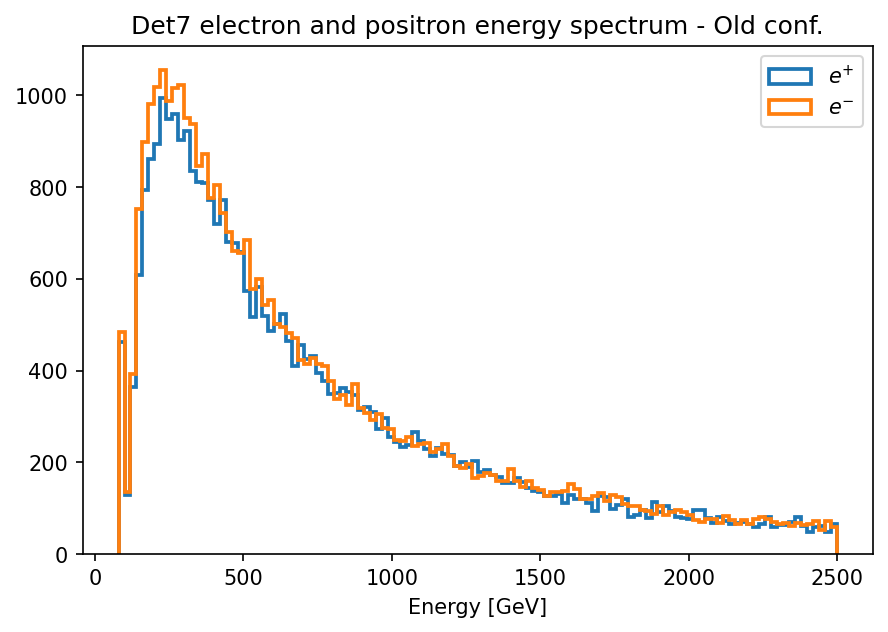

In [181]:
binning = 120
plt.figure(figsize = (6.8, 4.4), dpi = 150)
p_po_D_hist = plt.hist(p_po_D ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,  label = r'$e^{+}$')
p_el_D_hist = plt.hist(p_el_D ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,   label = r'$e^{-}$')
plt.xlabel('Energy [GeV]') 
plt.title('Det7 electron and positron energy spectrum - Old conf.')
plt.legend()

In [147]:
sum(p_el_D_hist[0])

np.float64(6673.0)

## New configuration, field halved


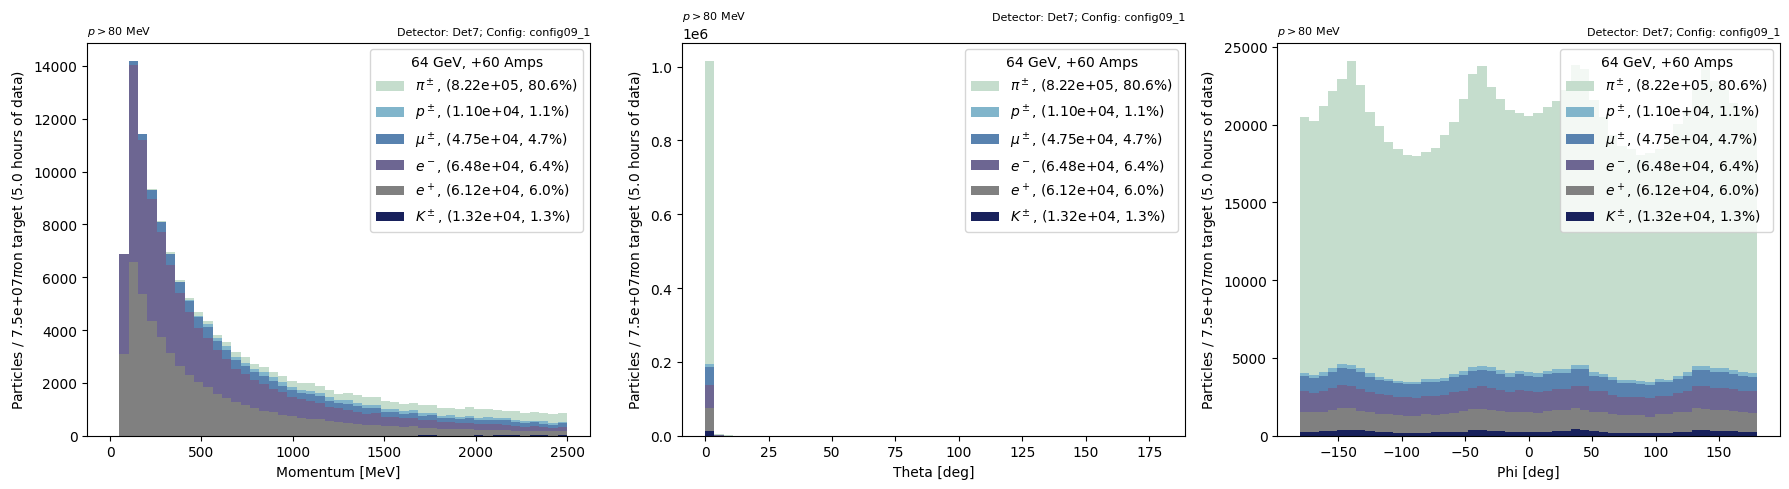

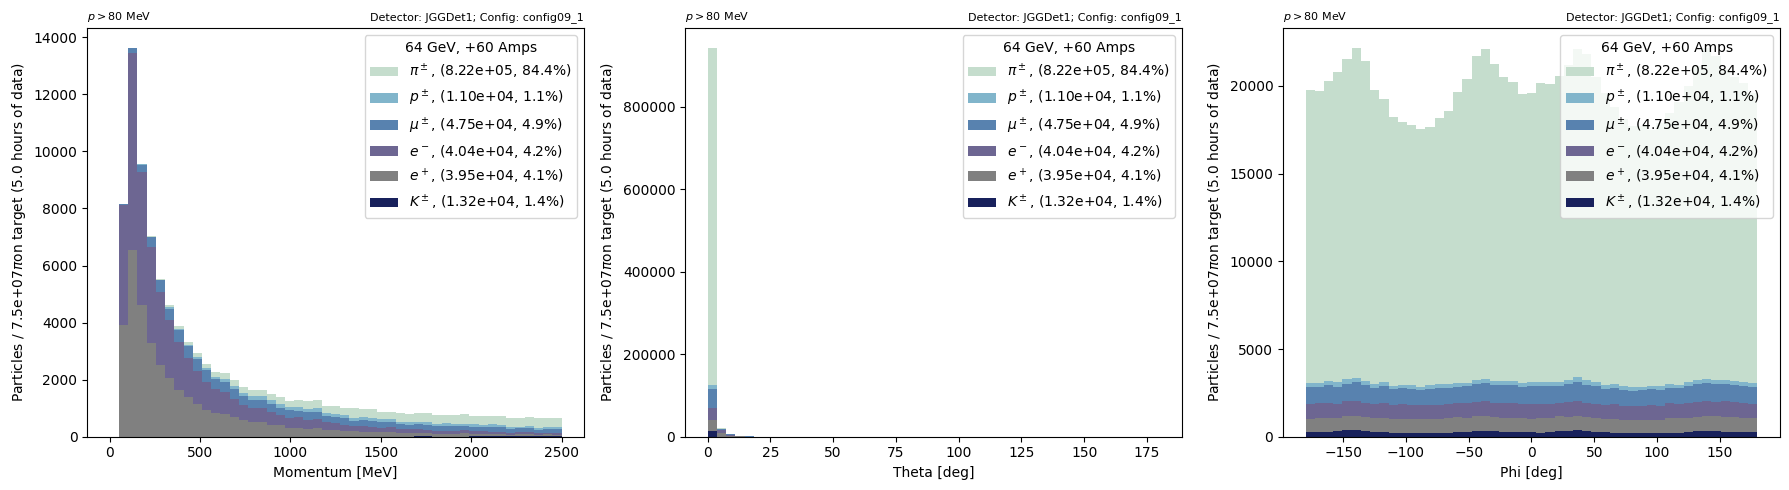

In [74]:
for det in ['Det7', 'JGGDet1']:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [MeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    for i, variable in enumerate(['p', 'theta', 'phi']):

        p_cut = 80

        values, labels = get_values_labels(df2, det, variable, p_cut)
    
        bins = x_bins[variable]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        ax[i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps')
    
        ax[i].set_xlabel(x_axis[variable])
        ax[i].set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
        ax[i].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
        ax[i].set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)
        
        # if det == 'Det7' or det == 'Det8' or 'JGG' in det:
        #     ax[i].set_yscale('log')
        if variable == "p" and det == 'JGGDet1':
            p_el_J = values[2]  # electrons momenta
            p_po_J = values[1]  # positrons momenta
            p_el_J = [i for i in p_el_J if i < 2500]
            p_po_J = [i for i in p_po_J if i < 2500]
        if variable == "p" and det == 'Det7':
            p_el_D = values[2]  # electrons momenta
            p_po_D = values[1]  # positrons momenta
            p_el_D = [i for i in p_el_D if i < 2500]
            p_po_D = [i for i in p_po_D if i < 2500]
    
    plt.tight_layout()
    # plt.savefig(_save_dir + f'spectra_g4blsimple_df_{config}_det{det}.pdf')
    plt.show()


In [75]:
print('JGGDet1')
print("The mean energy and its error in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J)/np.sqrt(len(p_el_J)))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J)/np.sqrt(len(p_po_J)))


JGGDet1
The mean energy and its error in for electrons are respctively (in MeV) 
440.81387 2.3698935899600646
The mean energy and its std in for positrons are respctively (in MeV) 
444.88187 2.4058648738318933


In [76]:
m_J_po = np.argmax((max(p_po_J_hist[0])))
print(m_J_po)
print(f"The maximum number of events for positrons happens for {p_po_J_hist[1][m_J_po]:.2f} MeV, with {int(max(p_po_J_hist[0]))} events")
m_J_el = np.argmax((max(p_po_J_hist[0])))
print(m_J_el)
print(f"The maximum number of events for positrons happens for {p_el_J_hist[1][m_J_el]:.2f} MeV, with {int(max(p_el_J_hist[0]))} events")




0
The maximum number of events for positrons happens for 80.03 MeV, with 603 events
0
The maximum number of events for positrons happens for 80.01 MeV, with 392 events


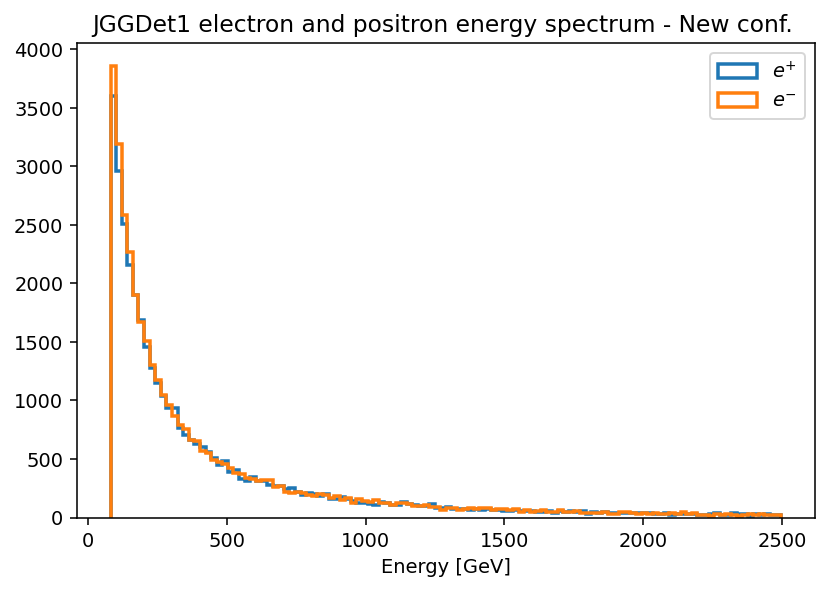

In [77]:
binning = 120
plt.figure(figsize = (6.8, 4.4), dpi = 140)
p_po_J_hist = plt.hist(p_po_J ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,  label = r'$e^{+}$')
p_el_J_hist = plt.hist(p_el_J ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,   label = r'$e^{-}$')
plt.xlabel('Energy [GeV]') 
plt.title('JGGDet1 electron and positron energy spectrum - New conf. ')
plt.legend()

In [78]:
m_J_po = np.argmax((max(p_po_J_hist[0])))
print(m_J_po)
print(f"The maximum number of events for positrons happens for {p_po_J_hist[1][m_J_po]:.2f} MeV, with {int(max(p_po_J_hist[0]))} events")
m_J_el = np.argmax((max(p_po_J_hist[0])))
print(m_J_el)
print(f"The maximum number of events for positrons happens for {p_el_J_hist[1][m_J_el]:.2f} MeV, with {int(max(p_el_J_hist[0]))} events")




0
The maximum number of events for positrons happens for 80.00 MeV, with 3596 events
0
The maximum number of events for positrons happens for 80.00 MeV, with 3857 events


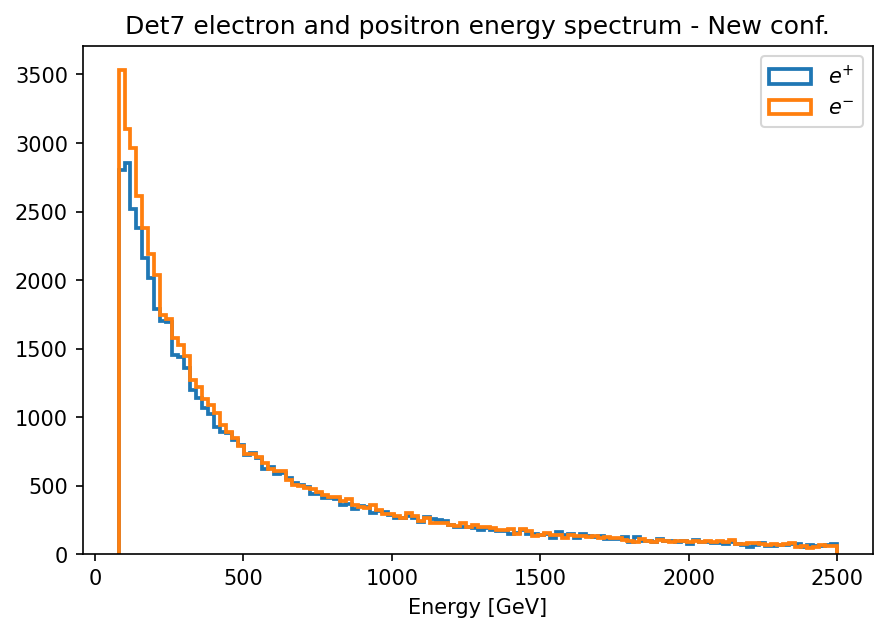

In [79]:
binning = 120
plt.figure(figsize = (6.8, 4.4), dpi = 150)
p_po_D_hist = plt.hist(p_po_D ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,  label = r'$e^{+}$')
p_el_D_hist = plt.hist(p_el_D ,bins = binning, stacked = True, fill = False, histtype = 'step', linewidth = 1.8,   label = r'$e^{-}$')
plt.xlabel('Energy [GeV]') 
plt.title('Det7 electron and positron energy spectrum - New conf.')
plt.legend()

In [80]:
print('JGGDet1')
print("The mean energy and its std in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J))


JGGDet1
The mean energy and its std in for electrons are respctively (in MeV) 
440.81387 462.41476
The mean energy and its std in for positrons are respctively (in MeV) 
444.88187 463.7332


In [81]:
print('JGGDet1')
print("The mean energy and its std in for electrons are respctively (in MeV) ")
print(np.mean(p_el_J), np.std(p_el_J))
print("The mean energy and its std in for positrons are respctively (in MeV) ")
print(np.mean(p_po_J), np.std(p_po_J))


JGGDet1
The mean energy and its std in for electrons are respctively (in MeV) 
440.81387 462.41476
The mean energy and its std in for positrons are respctively (in MeV) 
444.88187 463.7332


Some considerations: 
* Why do we cut the momentum over 2500 MeVs? Because we're intrested in this kind of event
* Why do we cut the momentum under 80 MeVs?  Beacuse they're hard to detect under 50
* $\sigma \approx \mu$, and the shape is quite exponential. I don't know if it is of any intrest
* Do we want to do a Kolmogorov... ? No


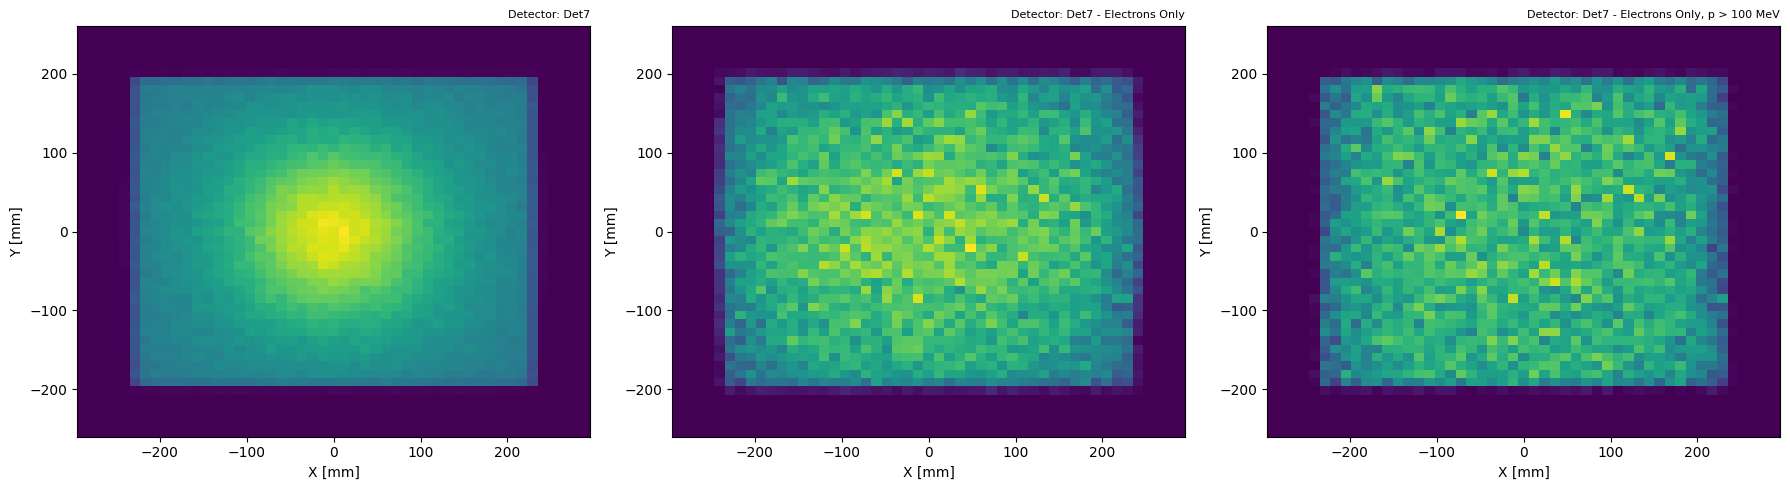

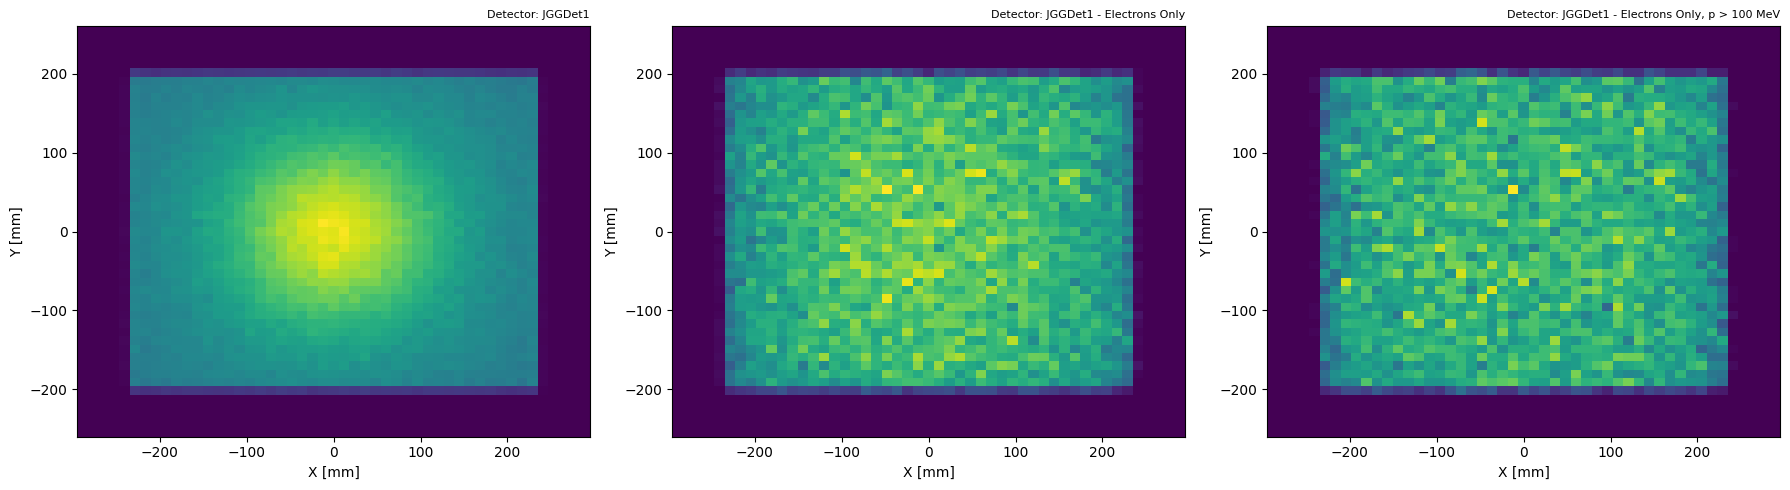

In [82]:
for det in ['Det7', 'JGGDet1']:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    xbins = np.linspace(-235-60, 235+60, 50)
    ybins = np.linspace(-200-60, 200+60, 50)
    if det == 'Det4':
        xbins = np.linspace(-64-1195.0827-10, 64-1195.0827+10, 50)
        ybins = np.linspace(-62.5-20.4724-10, 62.5-20.4724+10, 50)
    ax[0].hist2d(df[f'x_{det}'].values, df[f'y_{det}'].values, bins=[xbins, ybins])
    ax[0].set_xlabel('X [mm]')
    ax[0].set_ylabel('Y [mm]')
    ax[0].set_title(f'Detector: {det}', loc='right', fontsize=8)

    # mask_e = np.abs(pdg) == 11
    ax[1].hist2d(df.query('abs(PDGid)==11')[f'x_{det}'], df.query('abs(PDGid)==11')[f'y_{det}'], bins=[xbins, ybins])
    ax[1].set_xlabel('X [mm]')
    ax[1].set_ylabel('Y [mm]')
    ax[1].set_title(f'Detector: {det} - Electrons Only', loc='right', fontsize=8)

    # mask_p = particle.p > 200
    ax[2].hist2d(df.query('abs(PDGid)==11 and Pz_JGGDet1 > 100')[f'x_{det}'], df.query('abs(PDGid)==11 and Pz_JGGDet1 > 100')[f'y_{det}'], bins=[xbins, ybins])
    ax[2].set_xlabel('X [mm]')
    ax[2].set_ylabel('Y [mm]')
    ax[2].set_title(f'Detector: {det} - Electrons Only, p > 100 MeV', loc='right', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimple_df_pos_{config}_det{det}.pdf')
    plt.show()


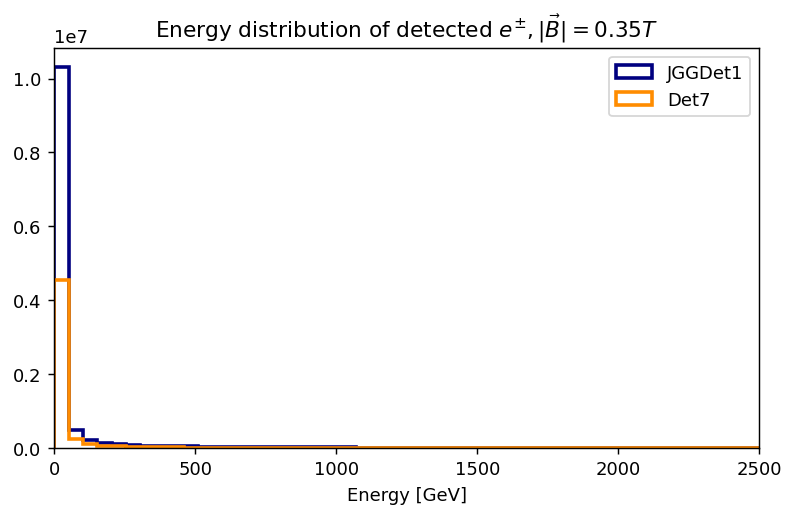

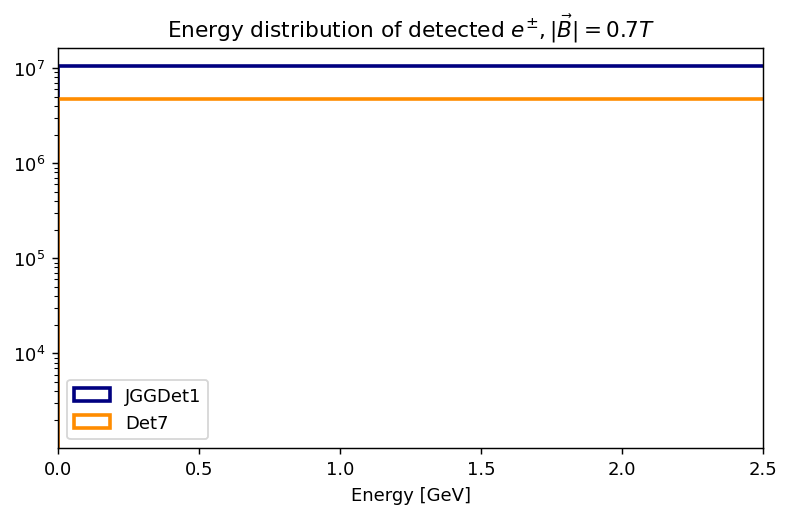

In [83]:
binning  = np.linspace(0, 2500, 50)
plt.figure(figsize = (7, 4), dpi = 130)
Jggdet1 =plt.hist(dfs['JGGDet1'].P, bins= binning,  label = 'JGGDet1', fill = False, color = 'navy', stacked = False, histtype='step', linewidth = 2)

#plt.xlim(0,0.001)
plt.xlabel('Energy [GeV]') 
#plt.xscale('log')
plt.title(r'Energy distribution of detected $e^{\pm} ,| \vec{B} | = 0.35 T$')  
Det7 =plt.hist(dfs['Det7'].P, bins= binning, label = 'Det7', fill = False, color = 'darkorange', stacked = False, histtype='step', linewidth = 2)
#plt.yscale('log')
plt.legend()
plt.savefig('B havled.jpg')
plt.xlim(0,2500)
plt.show()
plt.figure(figsize = (7, 4), dpi = 130)
Jggdet1_1 =plt.hist(dfs1['JGGDet1'].P, bins= binning, label = 'JGGDet1', fill = False, color = 'navy', stacked = False, histtype='step', linewidth = 2)
plt.yscale('log')
plt.xlabel('Energy [GeV]') #check if it is really like this!!!!
#plt.xscale('log')

plt.title(r'Energy distribution of detected $e^{\pm} , | \vec{B} | = 0.7 T$')  
Det7_1 =plt.hist(dfs1['Det7'].P, bins= binning, label = 'Det7', fill = False, color = 'darkorange', stacked = False, histtype='step', linewidth = 2)
plt.xlim(0,2.5)

plt.savefig('B normal.jpg')

plt.legend()